In [1]:
import numpy as np
import os 
from natsort import natsorted
import h5py
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib
from sklearn.decomposition import NMF
import pandas as pd
import re
import mne 
from mne.viz import plot_alignment, snapshot_brain_montage
from scipy.stats import sem
import matplotlib.lines as mlines
from scipy.signal import find_peaks
import matplotlib.patches as mpatches
import mne 
from mne.viz import plot_alignment, snapshot_brain_montage
from scipy.stats import sem
import matplotlib.lines as mlines
from scipy.signal import find_peaks
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import zscore

In [2]:
acoutipe = "SpectralFlux"  
datatipe = "HFa" 
patient_id = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11']
path = "data\\coherence\\"+ datatipe + "\\" + acoutipe + "\\real\\"

In [3]:
full_x =[]
full_y =[]
full_z =[]

full_data = []
full_cond = []
full_normatives_names =[]
full_plot_names = []
full_common_names = []
full_caths =[]
full_anods =[]
suj_ids = []

for patient in patient_id:
    spectral_flux = h5py.File(path + patient+ ".h5" ,"r")
    spectral_flux_data = np.asarray(spectral_flux[patient])
    freqs = np.asarray(spectral_flux[patient].attrs['freqs'])
    plot_names = np.asarray(spectral_flux[patient].attrs['ch_names'])
    
    syllabic = np.asarray(spectral_flux[patient].attrs['syll_id'])
    phon = np.asarray(spectral_flux[patient].attrs['phon_id'])
    spectral_flux.close()
    p_info = pd.read_csv("C:\\Users\\Jeremy\\Desktop\\github_syll_phon\\data\\anatomy\\"+ patient +".csv")
    
    # retrieve data only from electrodes that are within the brain and without artefacts
    common_names = []
    for i in plot_names:
        al = i.split('bi')[1]
        lts = re.findall(r'\D+', al)[0]
        nbo,nbt = re.findall(r'\d+', al)
        nee = lts+'_'+nbo+'_'+nbt
        common_names.append(nee)
        
    common_names = np.asarray(common_names)
    caths = []
    anods = []
    posxyz = []
    gind = []
    for num,i in enumerate(common_names):
        if i in p_info['ch_names'].values:
            posxyz.append(p_info.loc[p_info['ch_names'] == i][['x','y','z']].values)
            caths.append(p_info.loc[p_info['ch_names'] == i]['cathodes'].values[0])
            anods.append(p_info.loc[p_info['ch_names'] == i]['anodes'].values[0])
            gind.append(num)
    
    posxyz = np.asarray(posxyz)[:,0,:]
    
    xs = np.asarray(np.repeat(posxyz[:,0],9))
    ys = np.asarray(np.repeat(posxyz[:,1],9))
    zs = np.asarray(np.repeat(posxyz[:,2],9))
    # create electrodes names in a patient specific manner so that we can latter plot in brain space
    normatives = np.repeat([patient+'_'+ ch for ch in common_names[gind]],9)
    restricted = spectral_flux_data[np.asarray(gind)]
    alplot_names = np.repeat(plot_names[np.asarray(gind)],9)
    final_commons = np.repeat(common_names[np.asarray(gind)],9)
    # create conditions specific label so that we can latter average more easily
    conds = np.tile(['3l','3m','3h','6l','6m','6h','9l','9m','9h'],len(gind))
    full_data.append(restricted.reshape(restricted.shape[0]*restricted.shape[1],239))
    full_cond.append(conds)
    full_common_names.append(final_commons)
    full_plot_names.append(alplot_names)
    full_normatives_names.append(normatives)
    suj_ids.append([patient]*len(alplot_names))
    full_x.append(xs)
    full_y.append(ys)
    full_z.append(zs)
    full_caths.append(np.repeat(caths,9))
    full_anods.append(np.repeat(anods,9))

In [4]:
# create big dataframe with info from all patients
moby = {    
    'patient_id':            np.concatenate(suj_ids),
    'common_name':      np.concatenate(full_common_names),
   'plot_name':         np.concatenate(full_plot_names),
    'normative_name':   np.concatenate(full_normatives_names),
    'x' :                 np.concatenate(full_x),
    'y' :                 np.concatenate(full_y),
    'z' :                 np.concatenate(full_z),
    'cathod' :           np.concatenate(full_caths),
    'anod' :              np.concatenate(full_anods),
    'conditions':         np.concatenate(full_cond)}

info = pd.DataFrame.from_dict(moby)


In [5]:
full_data = np.concatenate(full_data)

# Create Panel A

In [6]:
# subselect data and info based on the speech responsiveness of electrodes


# retrieve speech responsive contacts 
speech_responsive = pd.read_csv("data\\anatomy\\speech_responsive.csv")
speech_responsive = speech_responsive['selected'].values

full_data  = full_data[info.loc[info['normative_name'].isin(speech_responsive)].index.values]
info  = info.iloc[info.loc[info['normative_name'].isin(speech_responsive)].index.values]
info = info.reset_index(drop=True)

In [7]:
# create indexes to regroup data according to specific conditions
good_conds =[np.where(info["conditions"].values =='3l')[0],np.where(info["conditions"].values =='3m')[0],
              np.where(info["conditions"].values =='3h')[0],np.where(info["conditions"].values =='6l')[0],
              np.where(info["conditions"].values =='6m')[0],np.where(info["conditions"].values =='6h')[0],
              np.where(info["conditions"].values =='9l')[0],np.where(info["conditions"].values =='9m')[0],
              np.where(info["conditions"].values =='9h')[0]]

names_conds = ['3HZ low', '3Hz medium', '3Hz high',
               '6Hz low', '6Hz medium', '6Hz high',
               '9Hz low', '9Hz medium', '9Hz high']

colors = ['paleturquoise',"dodgerblue","navy","mistyrose","lightcoral","darkred","yellowgreen","green","darkslategray"]


In [8]:
pa1 = mlines.Line2D([0], [0], color=colors[0], lw=4)
pa2 = mlines.Line2D([0], [0], color=colors[1], lw=4)
pa3 = mlines.Line2D([0], [0], color=colors[2], lw=4)

pb1 = mlines.Line2D([0], [0], color=colors[3], lw=4)
pb2 =mlines.Line2D([0], [0], color=colors[4], lw=4)
pb3 = mlines.Line2D([0], [0], color=colors[5], lw=4)

pc1 =mlines.Line2D([0], [0], color=colors[6], lw=4)
pc2 = mlines.Line2D([0], [0], color=colors[7], lw=4)
pc3 =mlines.Line2D([0], [0], color=colors[8], lw=4)

pp = mlines.Line2D([], [], marker='^', linestyle='None',mec='k', mfc='grey', mew=1,
                          markersize=10,label='Syllabic timescale')

custom_lines = [mlines.Line2D([0], [0], color=colors[0], lw=4),
                mlines.Line2D([0], [0], color=colors[1], lw=4),
                mlines.Line2D([0], [0], color=colors[2], lw=4),
               mlines.Line2D([], [], marker='^', linestyle='None',mec='k', mfc='grey', mew=1,
                          markersize=22,label='Syllabic timescale')]

In [9]:
stats_path = "data\\coherence\\"+datatipe+"\\stats\\"
stats = np.load( stats_path + acoutipe + '_stats.npy' , allow_pickle=True)
stats = np.asarray(stats).reshape((3,3))

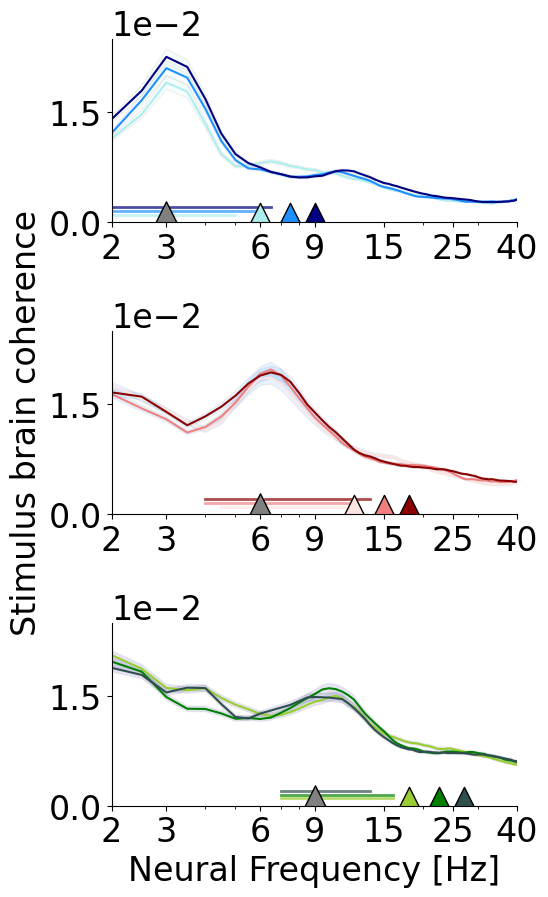

In [10]:
# Plot mean CaCoh across ALL subjects & ALL electrodes for each condition

name_cond = ['low', 'medium', 'high','low', 'medium', 'high', 'low', 'medium', 'high']
matplotlib.rcParams.update({'font.size': 24})

fig,axs = plt.subplots(3,1, figsize=(6,9.5))

idxx = [[0,1,2],[3,4,5],[6,7,8]]
alphas = [1,0.7,0.4]
condi = [3,6,9]
ys = [0.001, 0.0015, 0.002]
legs = [[pa1,pa2,pa3,pp],[pb1,pb2,pb3,pp],[pc1,pc2,pc3,pp]]

colors = ['paleturquoise',"dodgerblue","navy","mistyrose","lightcoral","darkred","yellowgreen","green","darkslategray"]


for i, (num,ax) in enumerate(zip(range(3),axs.ravel())) :
        for j in range(3):
            aldat = full_data[good_conds[idxx[i][j]]]#*np.sqrt(freqs)
            doto = np.mean(full_data[good_conds[idxx[i][j]]],0)#*np.sqrt(freqs)
            ax.plot(freqs,doto,color= colors[idxx[i][j]],label=name_cond[idxx[i][j]]);
            ax.fill_between(freqs,doto +sem(aldat),doto -sem(aldat),alpha = 0.1, edgecolor = 'grey', facecolor = colors[i] ) 
            ax.plot(stats[i][j],np.repeat(ys[j],len(stats[i][j])), color = colors[idxx[i][j]], linewidth = 2,zorder=0, alpha = 0.7 )
        if num == 0:
            ax.scatter(6,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='paleturquoise',zorder=1)
            ax.scatter(7.5,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='dodgerblue',zorder=1)
            ax.scatter(9,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='navy',zorder=1)

        
        if num == 1:
            ax.set_ylabel('Stimulus brain coherence',fontsize=24);
            ax.scatter(12,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='mistyrose',zorder=1)
            ax.scatter(15,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='lightcoral',zorder=1)
            ax.scatter(18,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='darkred',zorder=1)
        
        if num == 2:
            ax.scatter(18,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='yellowgreen',zorder=1)
            ax.scatter(22.5,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='green',zorder=1)
            ax.scatter(27,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='darkslategray',zorder=1)


        ax.spines['right'].set_visible(False)
        ax.scatter(condi[i],0.0005, marker='^',s = 575,linewidth=1,edgecolor='black',zorder=1, color='grey')
        ax.spines['top'].set_visible(False)
        ax.set_xlim(2,40)
        ax.set_ylim(0)
        ax.semilogx()   
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter());

        ax.set_xticks([2,3,6,9,15,25,40]);
        ax.set_yticks([0.0,0.015,0.03]);
        ax.set_ylim(0,0.025)  
ax.set_xlabel("Neural Frequency [Hz]",fontsize=24);
fig.tight_layout()
#fig.savefig( "figure4A",  dpi=300,  format="svg", metadata=None,facecolor=None, edgecolor=None , bbox_inches='tight')

In [11]:
# load broadband data and HFa data
raw_data = pd.read_csv("data\\HFa_broadband\\broadband\\"+acoutipe+"\\data.csv")
HG_data = pd.read_csv("data\\HFa_broadband\\HFa\\"+acoutipe+"\\data.csv")
raw_data = raw_data.loc[raw_data['normative_name'].isin(speech_responsive)]
HG_data = HG_data.loc[HG_data['normative_name'].isin(speech_responsive)]

# create combined dataframe
final_tobrain = raw_data[['normative_name', 'x','y','z']].copy()
final_tobrain['first_pk_amp'] = raw_data['first_pk_amp'].values - HG_data['first_pk_amp'].values
final_tobrain['second_pk_amp'] = raw_data['second_pk_amp'].values - HG_data['second_pk_amp'].values

Using notebook 3d backend.

Channel types::	seeg: 347


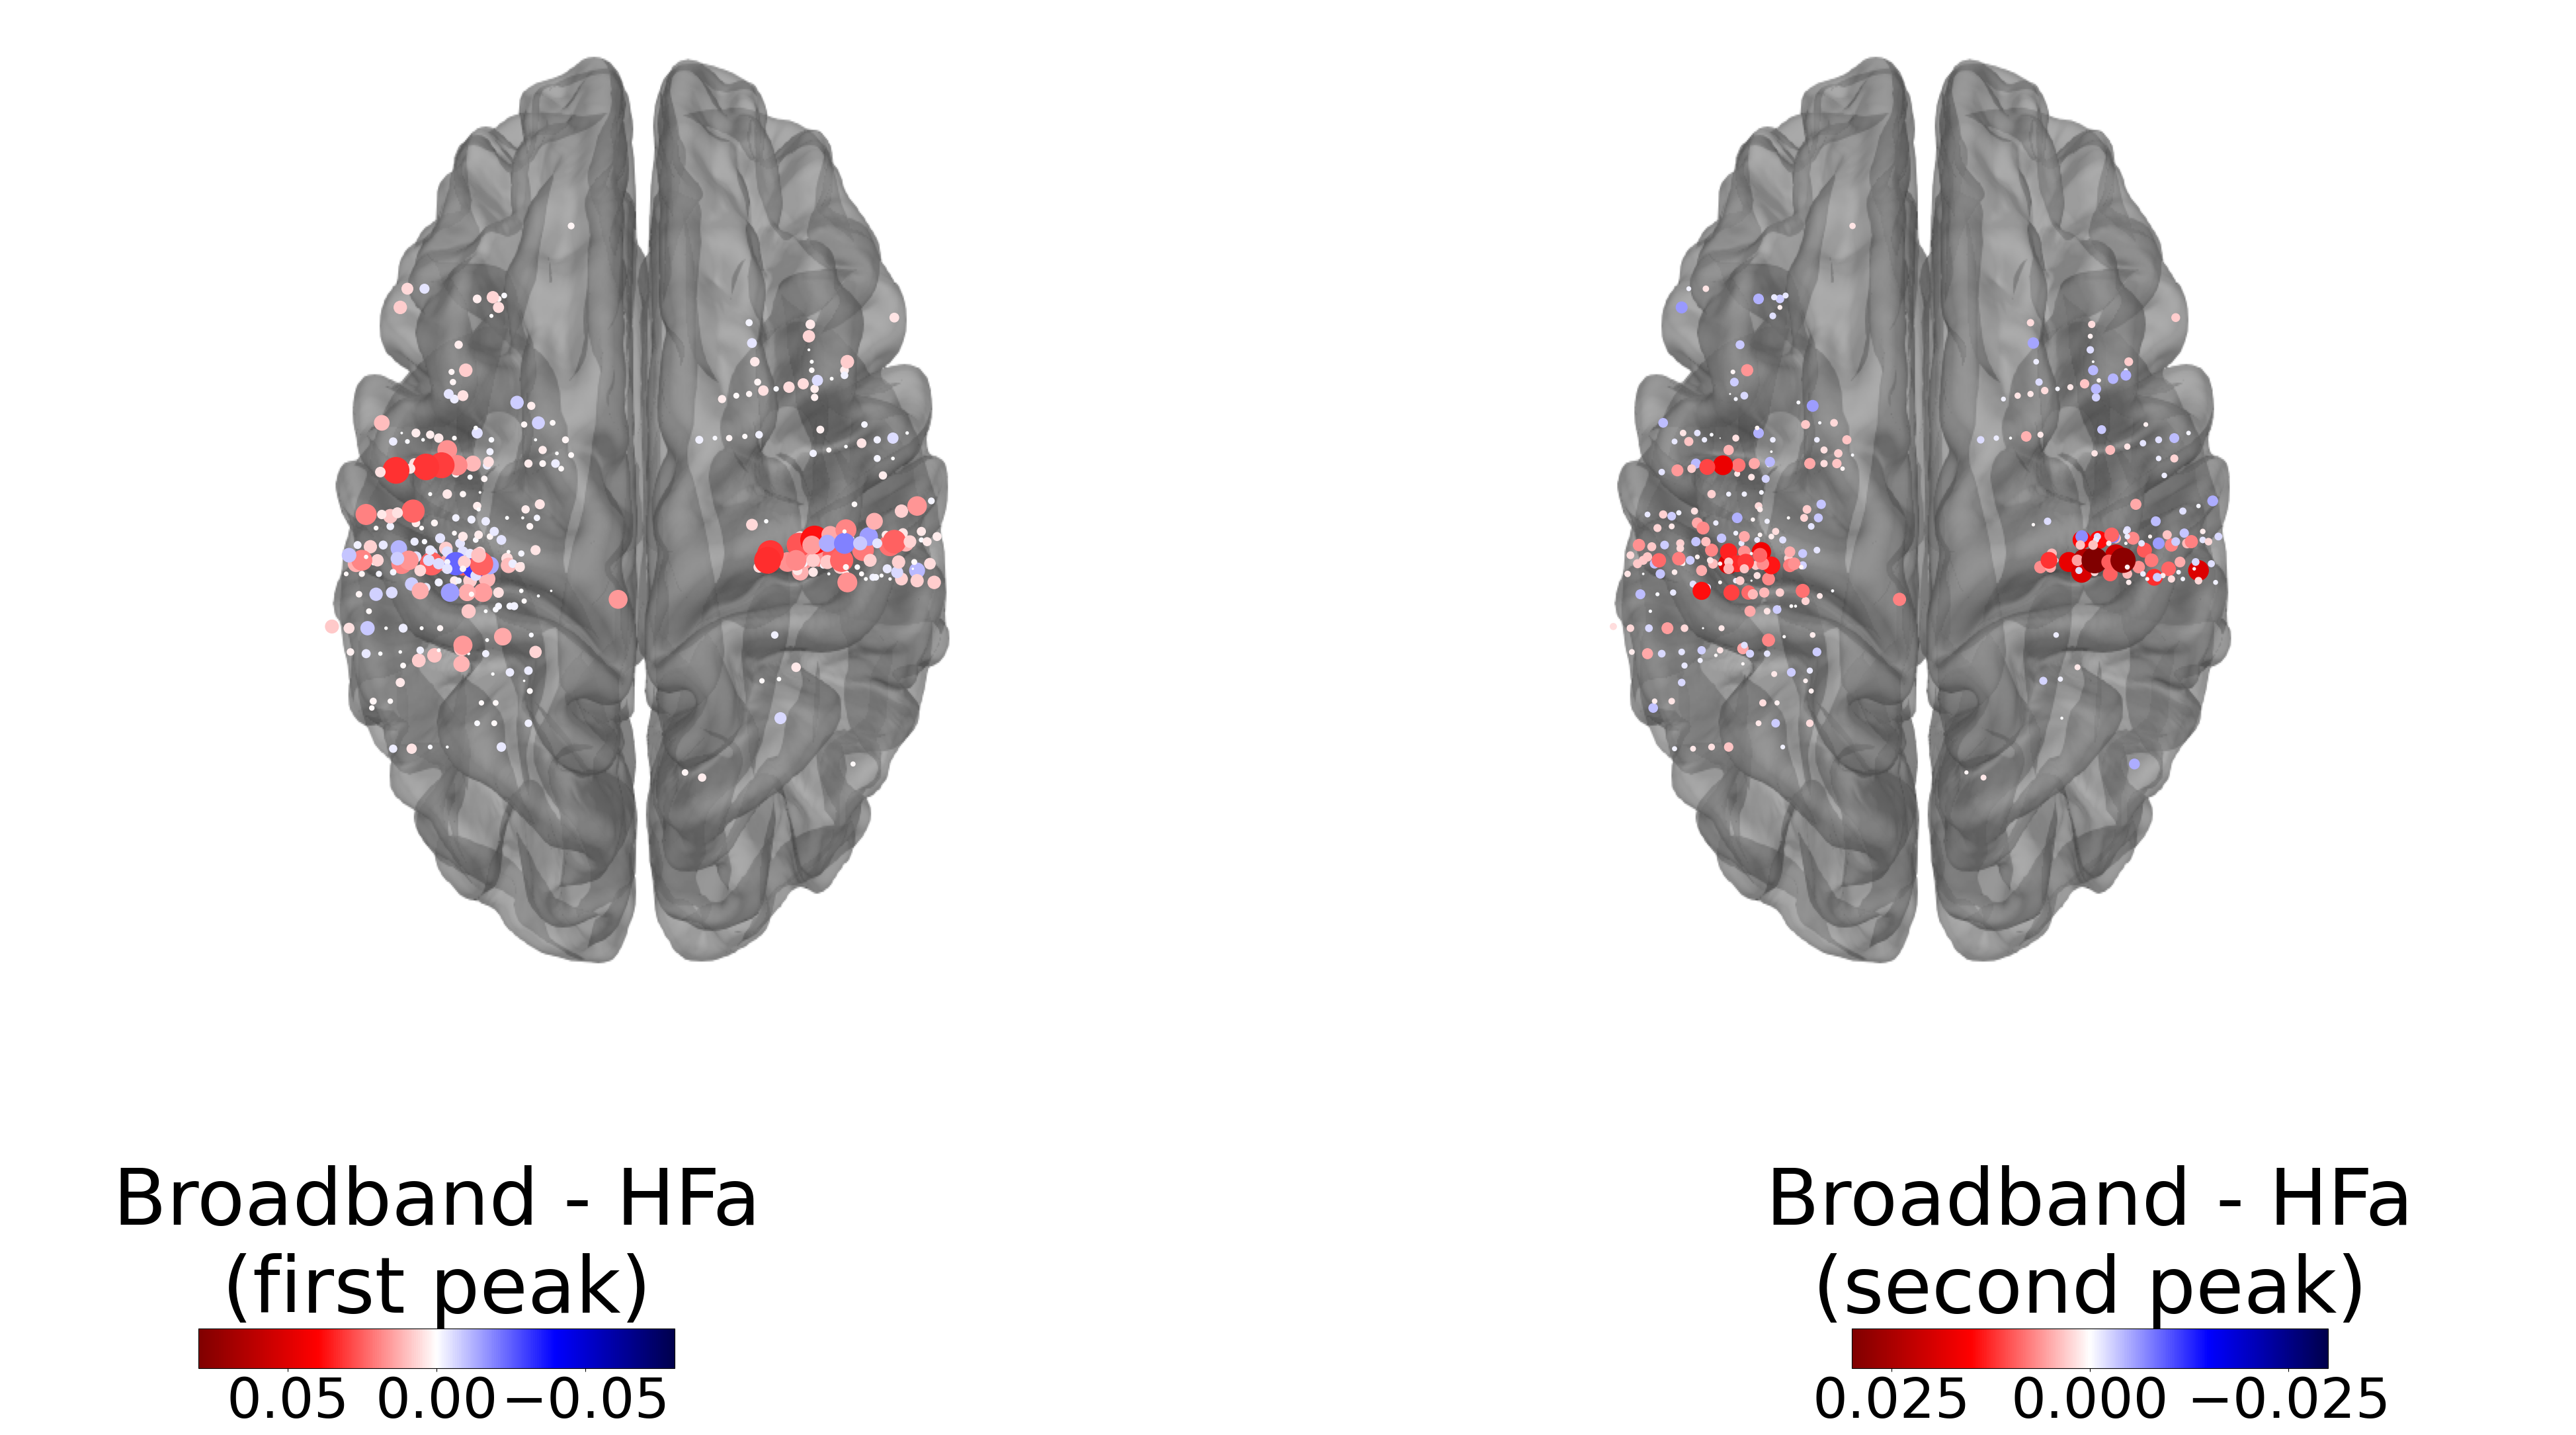

In [12]:
for i in ('x','y','z','first_pk_amp','second_pk_amp'):
    final_tobrain[i] = final_tobrain[i].astype(float)
datas_to_plot = [final_tobrain["first_pk_amp"].values,final_tobrain["second_pk_amp"].values]
ch_names = final_tobrain['normative_name'].values
loc = final_tobrain[['x','y','z']].values
# Declare montage
ch_pos = dict(zip(ch_names, loc))
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
info_ = mne.create_info(list(ch_names), 1000., ch_types='seeg').set_montage(montage)


mne.viz.set_3d_backend("notebook")
fig = mne.viz.create_3d_figure(size=(900, 600), bgcolor='white', scene=True)
subjects_dir = "C:\\Users\\Jeremy\\Desktop\\github_syll_phon\\data\\anatomy\\anatomy2\\"
trans =  mne.read_trans(subjects_dir + '\\fsaverage\\fsaverage-trans.fif')
surfaces = {'brain': 1}

fig =plot_alignment(info=info_,trans=trans,subject='fsaverage',subjects_dir=subjects_dir,
                 surfaces=['pial'],seeg=True, interaction='terrain',coord_frame='mri',fig=fig)

mne.viz.set_3d_view(fig,azimuth=0, elevation=-360,distance = 0.37)
xy, im = snapshot_brain_montage(fig, montage)
xy_pts1 = np.vstack([xy[ch] for ch in info_['ch_names']])

mne.viz.set_3d_view(fig,azimuth=180, elevation=360,distance = 0.37)
xy,im2 = snapshot_brain_montage(fig, montage)
xy_pts2 = np.vstack([xy[ch] for ch in info_['ch_names']])

images = [im2,im]
idxs = [0,1]
vmins = [-0.08,-0.03]
vmaxs = [0.08,0.03]
sizes = [35000,39000]
t = []

fig2, axs = plt.subplots(1,2,figsize=(50, 20))

for i,(ax,image,idx,vmin,vmax) in enumerate(zip(axs.ravel(),images,idxs,vmins,vmaxs)):

    ax.imshow(image, aspect='auto') 
    sizes = abs(datas_to_plot[idx])#abs()
    sizes=sizes*35000
    m = ax.scatter(*xy_pts2.T, c=datas_to_plot[idx],linewidths= 1, s=sizes*0.7, cmap="seismic", alpha=1, vmin=vmin , vmax=vmax) 
    nut = np.arange(0,len(datas_to_plot[idx]))
    ax.set_axis_off()
    t.append(m)

# Plot colorbar
cax1 = fig2.add_axes([0.17, -0.15, 0.17, 0.2])
cax1.set_axis_off()
cbar1 = plt.colorbar(t[0], ax=cax1, orientation='horizontal',aspect=12, pad=0)
cbar1.ax.invert_xaxis()
cbar1.ax.tick_params(labelsize=60)
cbar1.ax.set_title("Broadband - HFa\n(first peak)",fontsize=85);

cax2 = fig2.add_axes([0.67,-0.15, 0.17,0.2])
cax2.set_axis_off()
cbar = plt.colorbar(m, ax=cax2, orientation='horizontal',aspect=12, pad=0)
cbar.ax.invert_xaxis()
cbar.ax.tick_params(labelsize=60)
cbar.ax.set_title("Broadband - HFa\n(second peak)",fontsize=85);

plt.subplots_adjust(hspace=0, wspace=0)
#fig2.savefig("fig4B.png",  dpi=300,facecolor='white', edgecolor='white' , bbox_inches='tight')